In [1]:
# Import functions for graphing and methods (also includes some libraries needed for data analysis)
from graphing_funcs import *
from method_funcs import *
from daymet_funcs import * 

%matplotlib inline

# set style parameters for graphs
sns.set_style("darkgrid", {'axes.edgecolor': 'black'})
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams["legend.fontsize"] = 13
plt.rcParams['figure.dpi'] = 300

In [ ]:
# Define station number
s_num = 64

# Define threshold
threshold = 15

# Get estimates using min/max from daymet
daymet_est = daymet_daily_est(s_num, '2014-01-01', '2022-12-31', threshold)

# Create pivot table for station
s_pivot, years = create_pivot(s_num)

# Split data (estimation and validation sets)
s_pivot_e = s_pivot.iloc[:years[-1], :] # pull all data from start year - one before latest
s_pivot_v = s_pivot.iloc[years[-1]:, :] # pull all data from latest - end

# Get daily estimates of min/max (with filter applied)
temp_est = temp_bounds_modified(s_pivot_e, 0.99, threshold, 0.8, True)

# Get monthly estimates of delta values 
delta_est = get_delta_est(s_pivot_e, 0.9, 1)

# Generate graph with both daymet and das estimates to compare
daymet_vs_das_graph(temp_est, daymet_est, s_pivot_v, s_num)

### Sythetic Data

We use Daymet as "ground truth" values, assuming there are no errors, to create our validation data. We would expect the bounds to have 0 flags raised if the estimation are correct, so we can now quantify using cross validation at what point we find accurate parameters. Theoretically, this should work for both delta values and overall bounds, since the temperature is all correct with no irregular spikes.

In [3]:
syn_data = create_daymet_daily(s_num, '2023-01-01', '2023-12-31')

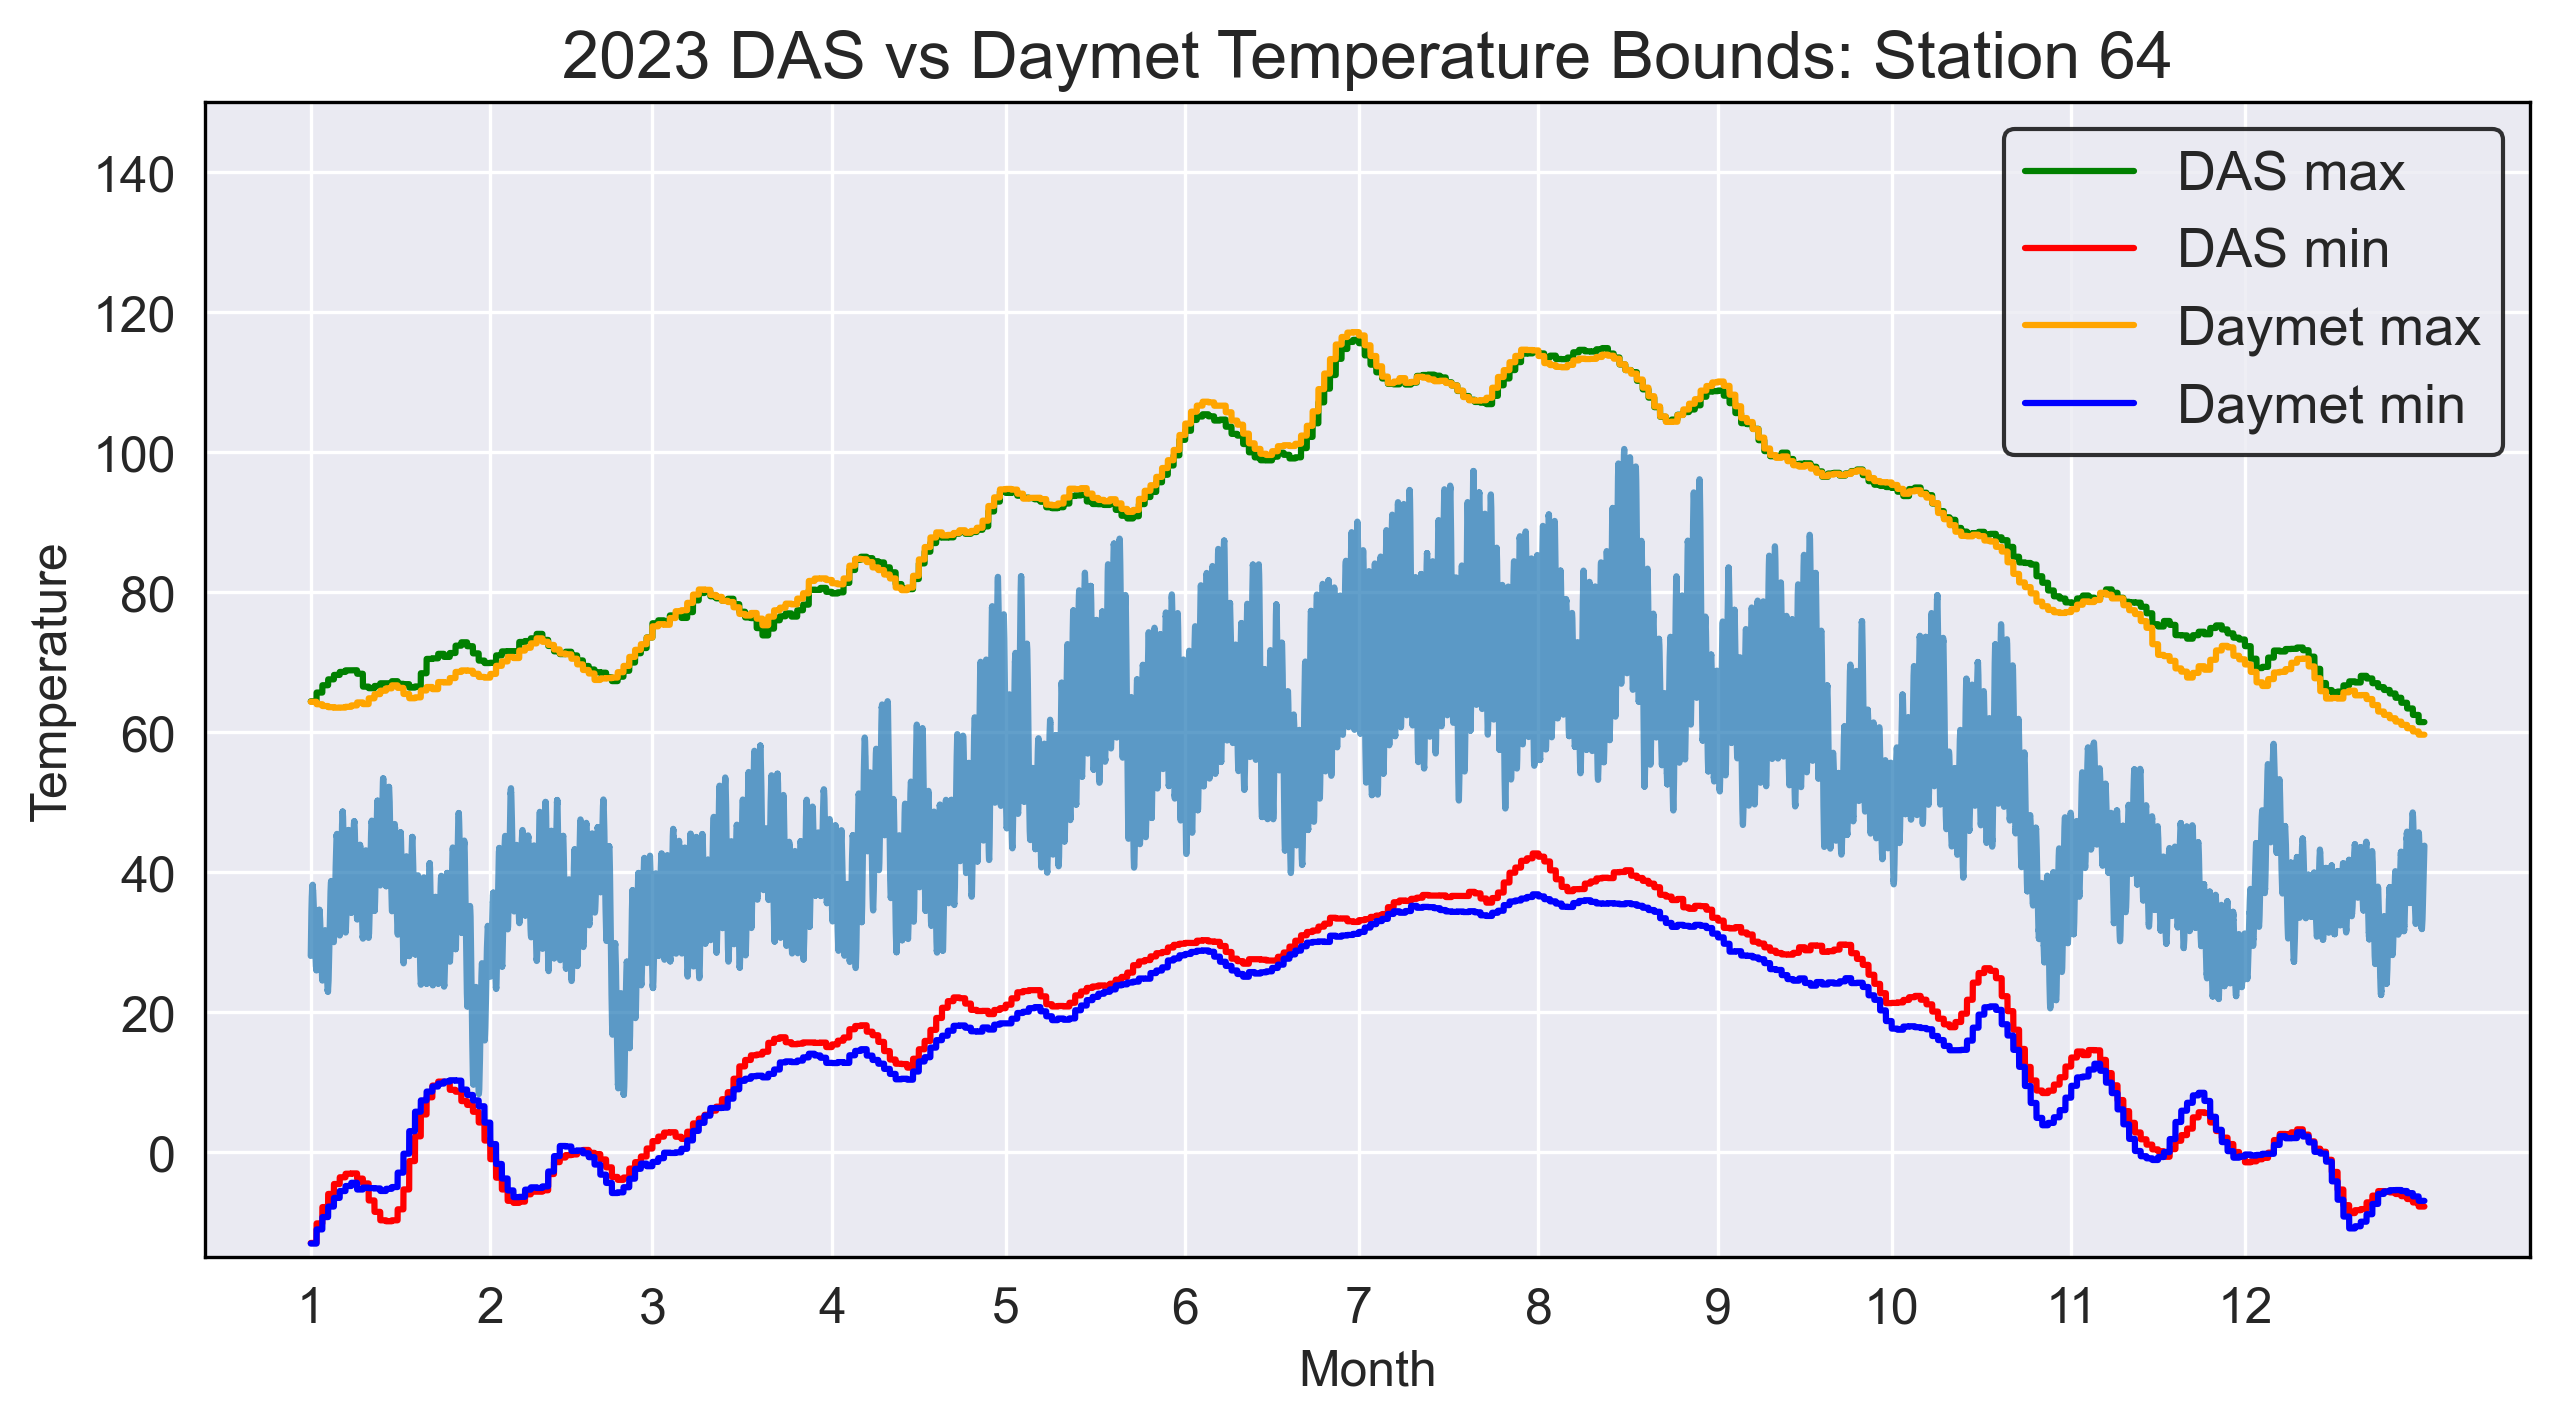

In [4]:
# Generate graph with both daymet and das estimates to compare, on synthetic data
daymet_vs_das_graph(temp_est, daymet_est, syn_data, s_num)

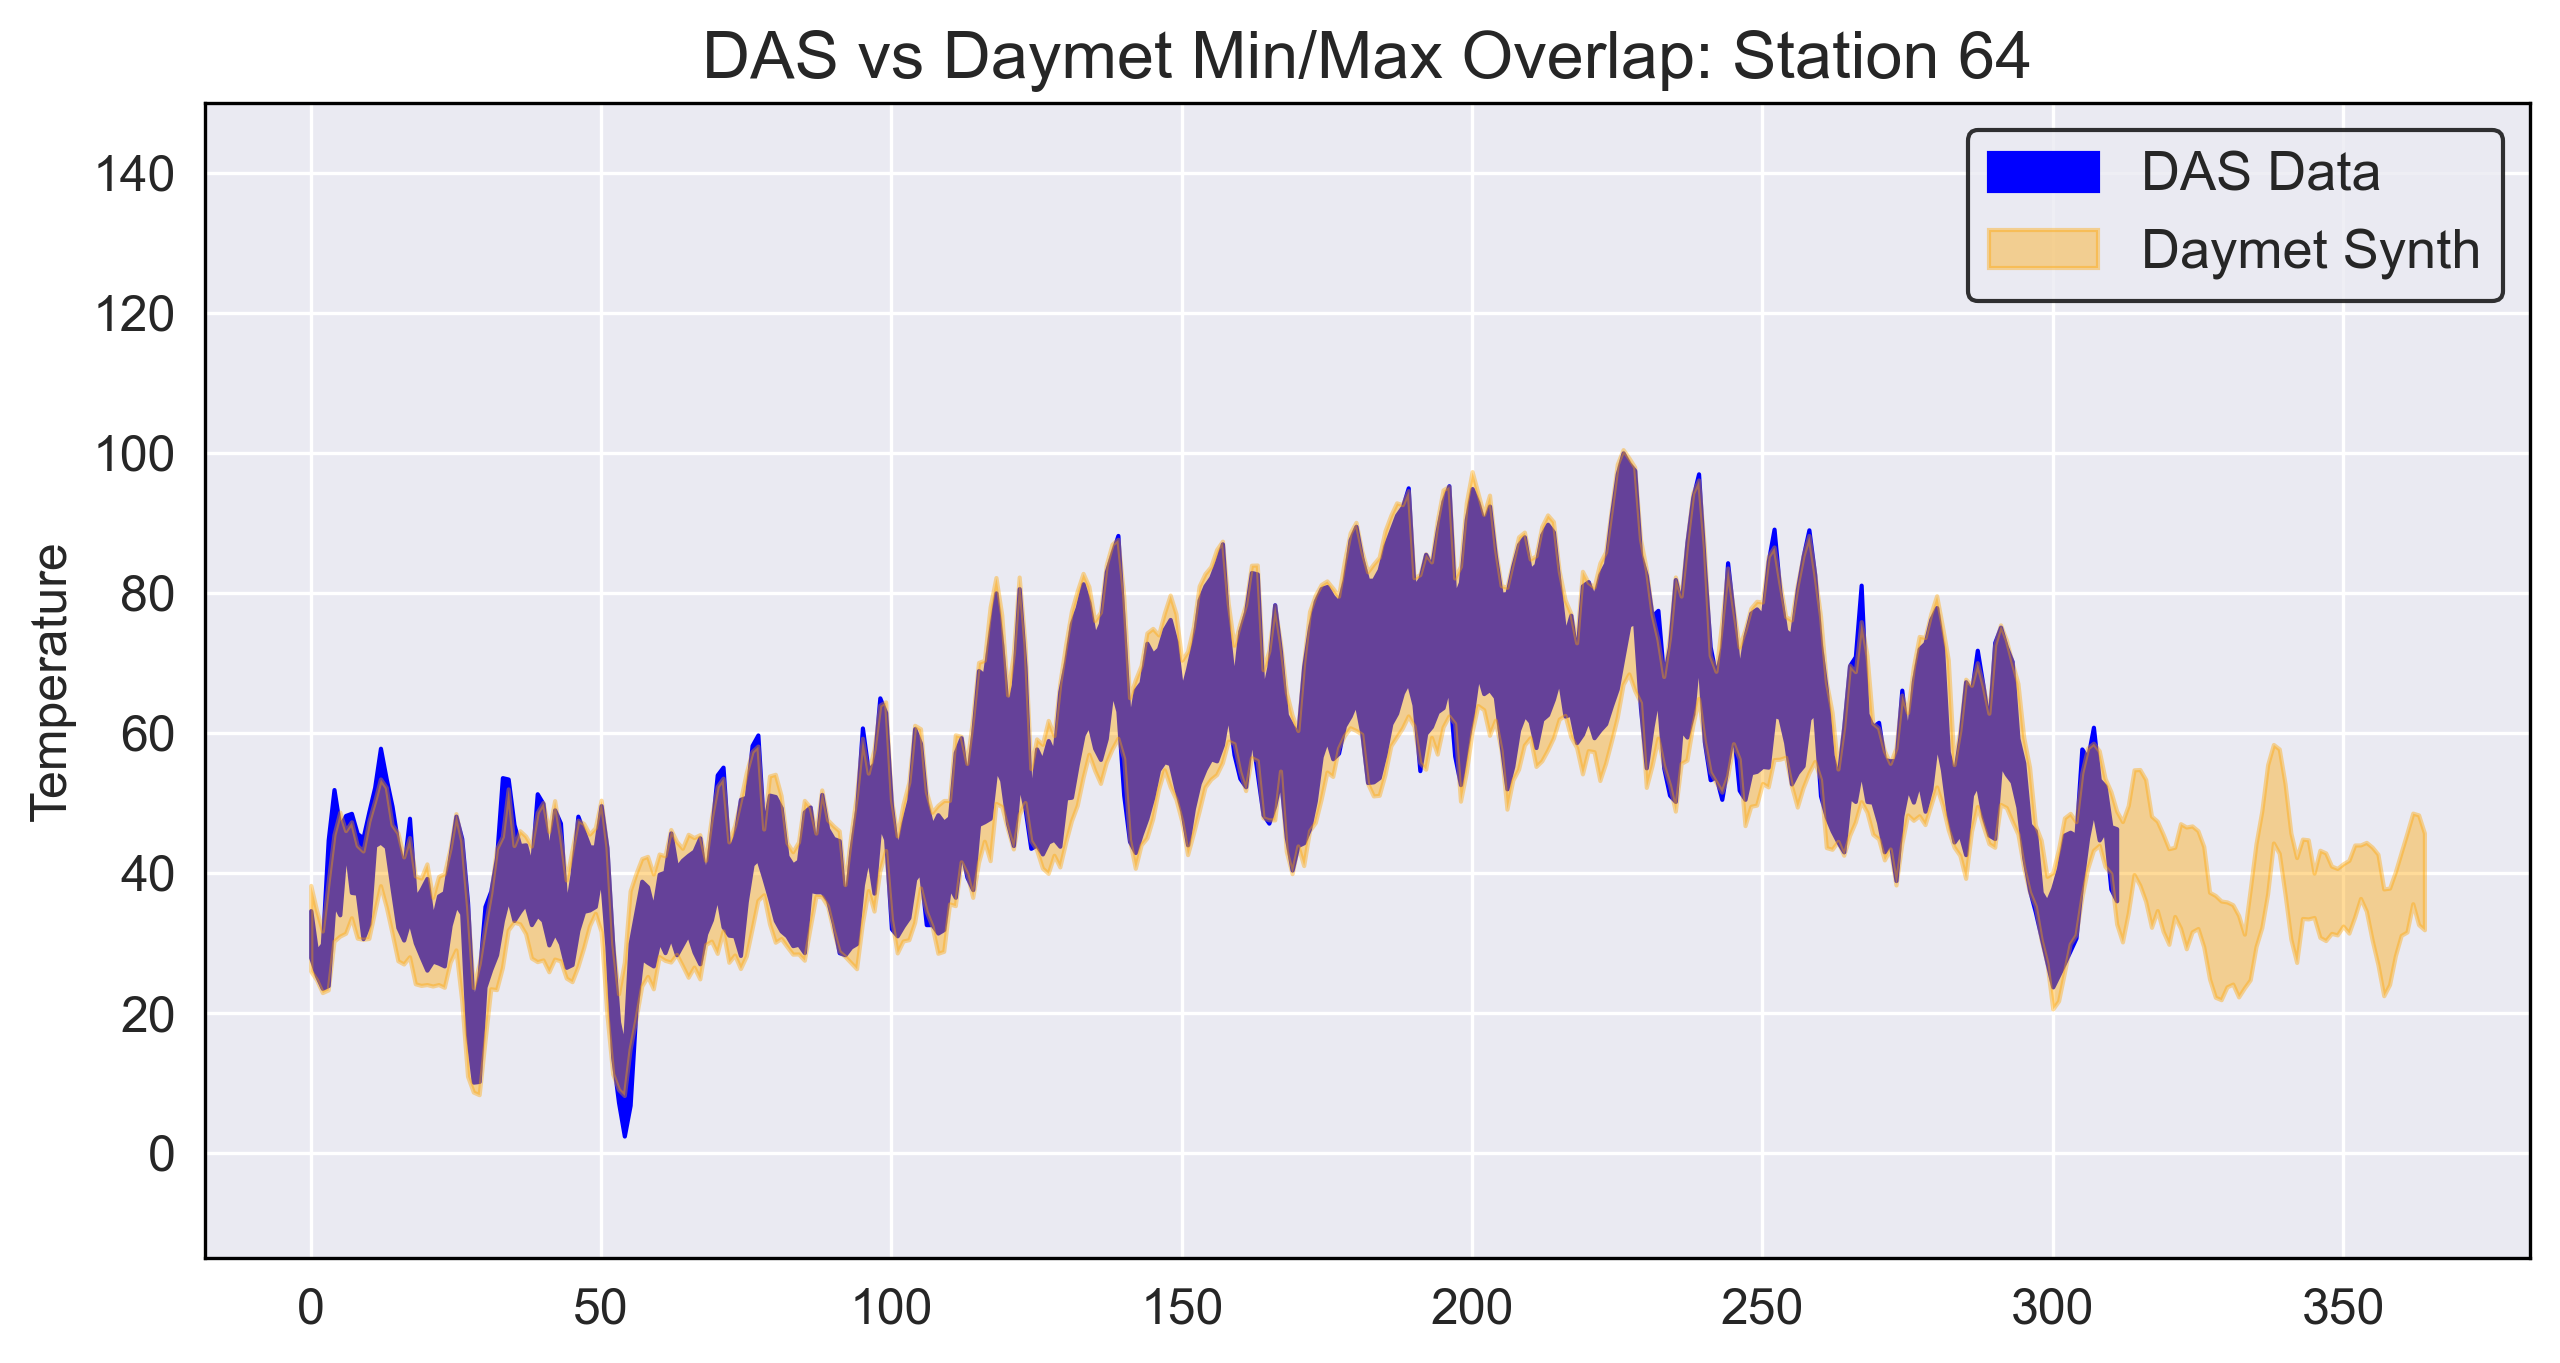

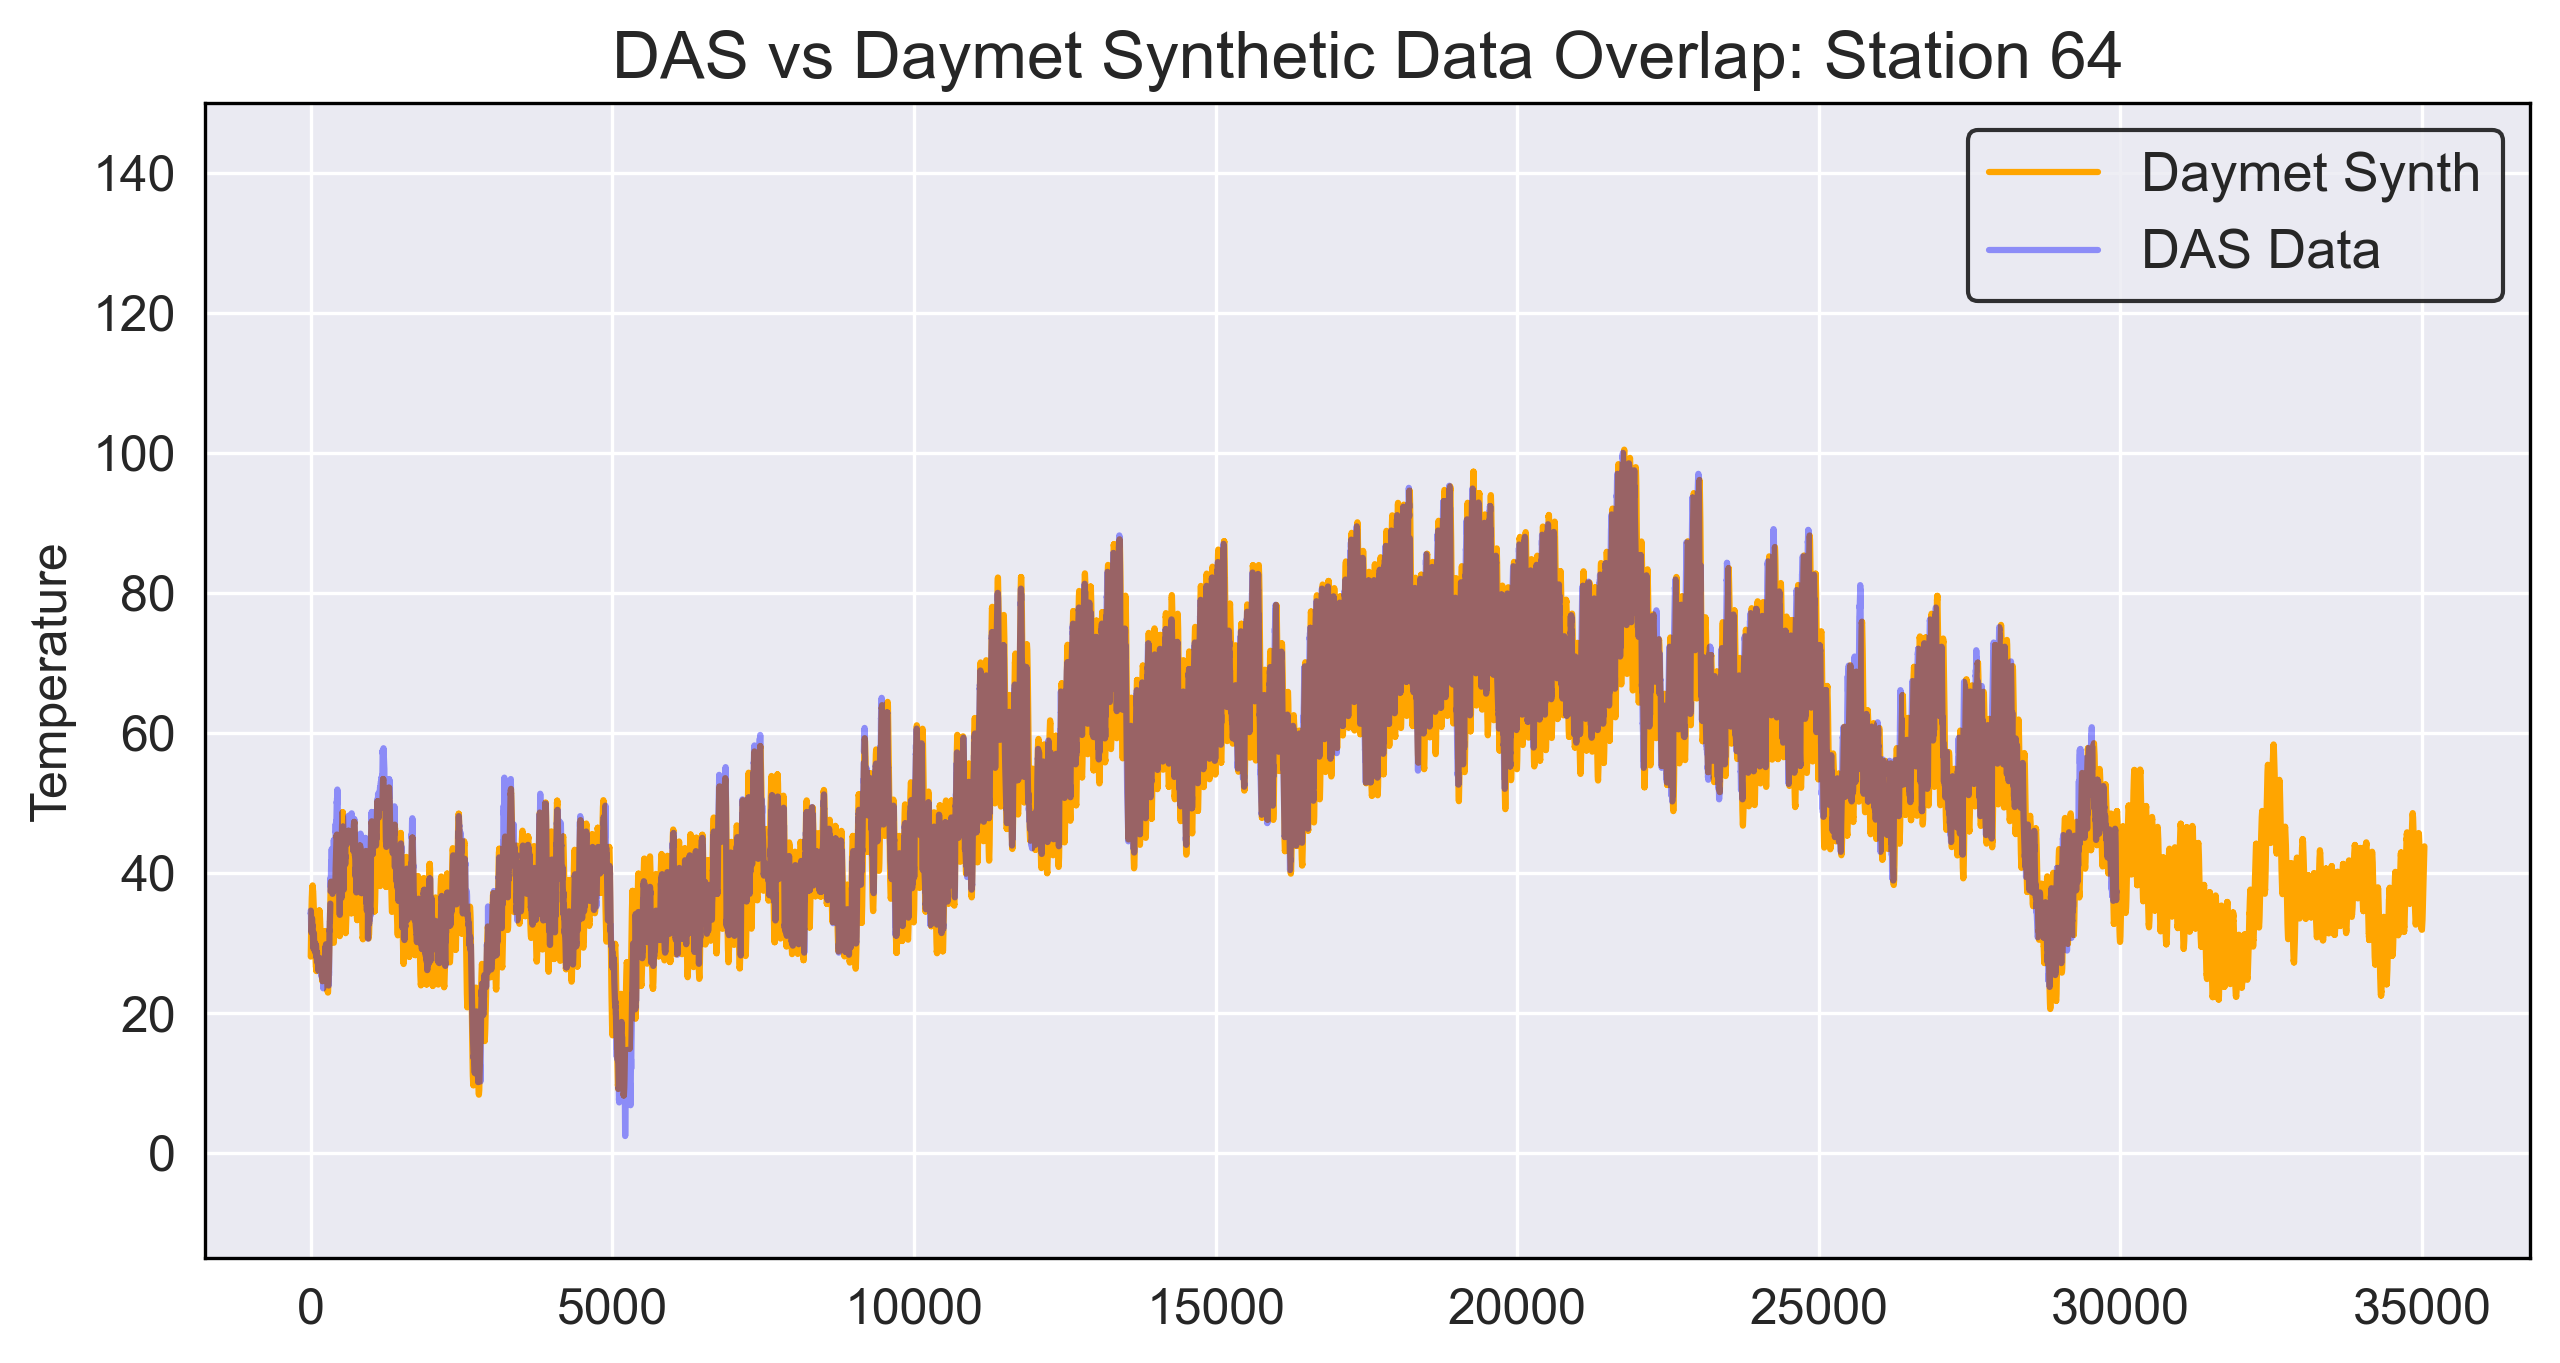

In [5]:
# Plot DAS and Daymet min/max to ensure they are similar
das_vals_min = s_pivot_v.min(axis=1).values
dm_vals_min = syn_data.min(axis=1).values

das_vals_max = s_pivot_v.max(axis=1).values
dm_vals_max = syn_data.max(axis=1).values

plt.figure(figsize=(10,5))
plt.fill_between(np.arange(0, len(das_vals_max)), das_vals_min, das_vals_max, label='DAS Data', color='blue')
plt.fill_between(np.arange(0, len(dm_vals_max)), dm_vals_min, dm_vals_max, label='Daymet Synth', color='orange', 
                 alpha=0.4)

plt.ylim(-15, 150)

plt.ylabel('Temperature')
plt.title(f'DAS vs Daymet Min/Max Overlap: Station {s_num}')
plt.grid(True)
plt.legend()
plt.show()

# Plot DAS and Daymet data to ensure they are similar
das_vals = s_pivot_v.values.flatten()
dm_vals = syn_data.values.flatten()

plt.figure(figsize=(10,5))
plt.plot(dm_vals, color='orange', label='Daymet Synth')
plt.plot(das_vals, color='blue', label='DAS Data', alpha=0.4)

plt.ylim(-15, 150)

plt.ylabel('Temperature')
plt.title(f'DAS vs Daymet Synthetic Data Overlap: Station {s_num}')
plt.grid(True)
plt.legend()
plt.show()

### Error Injection

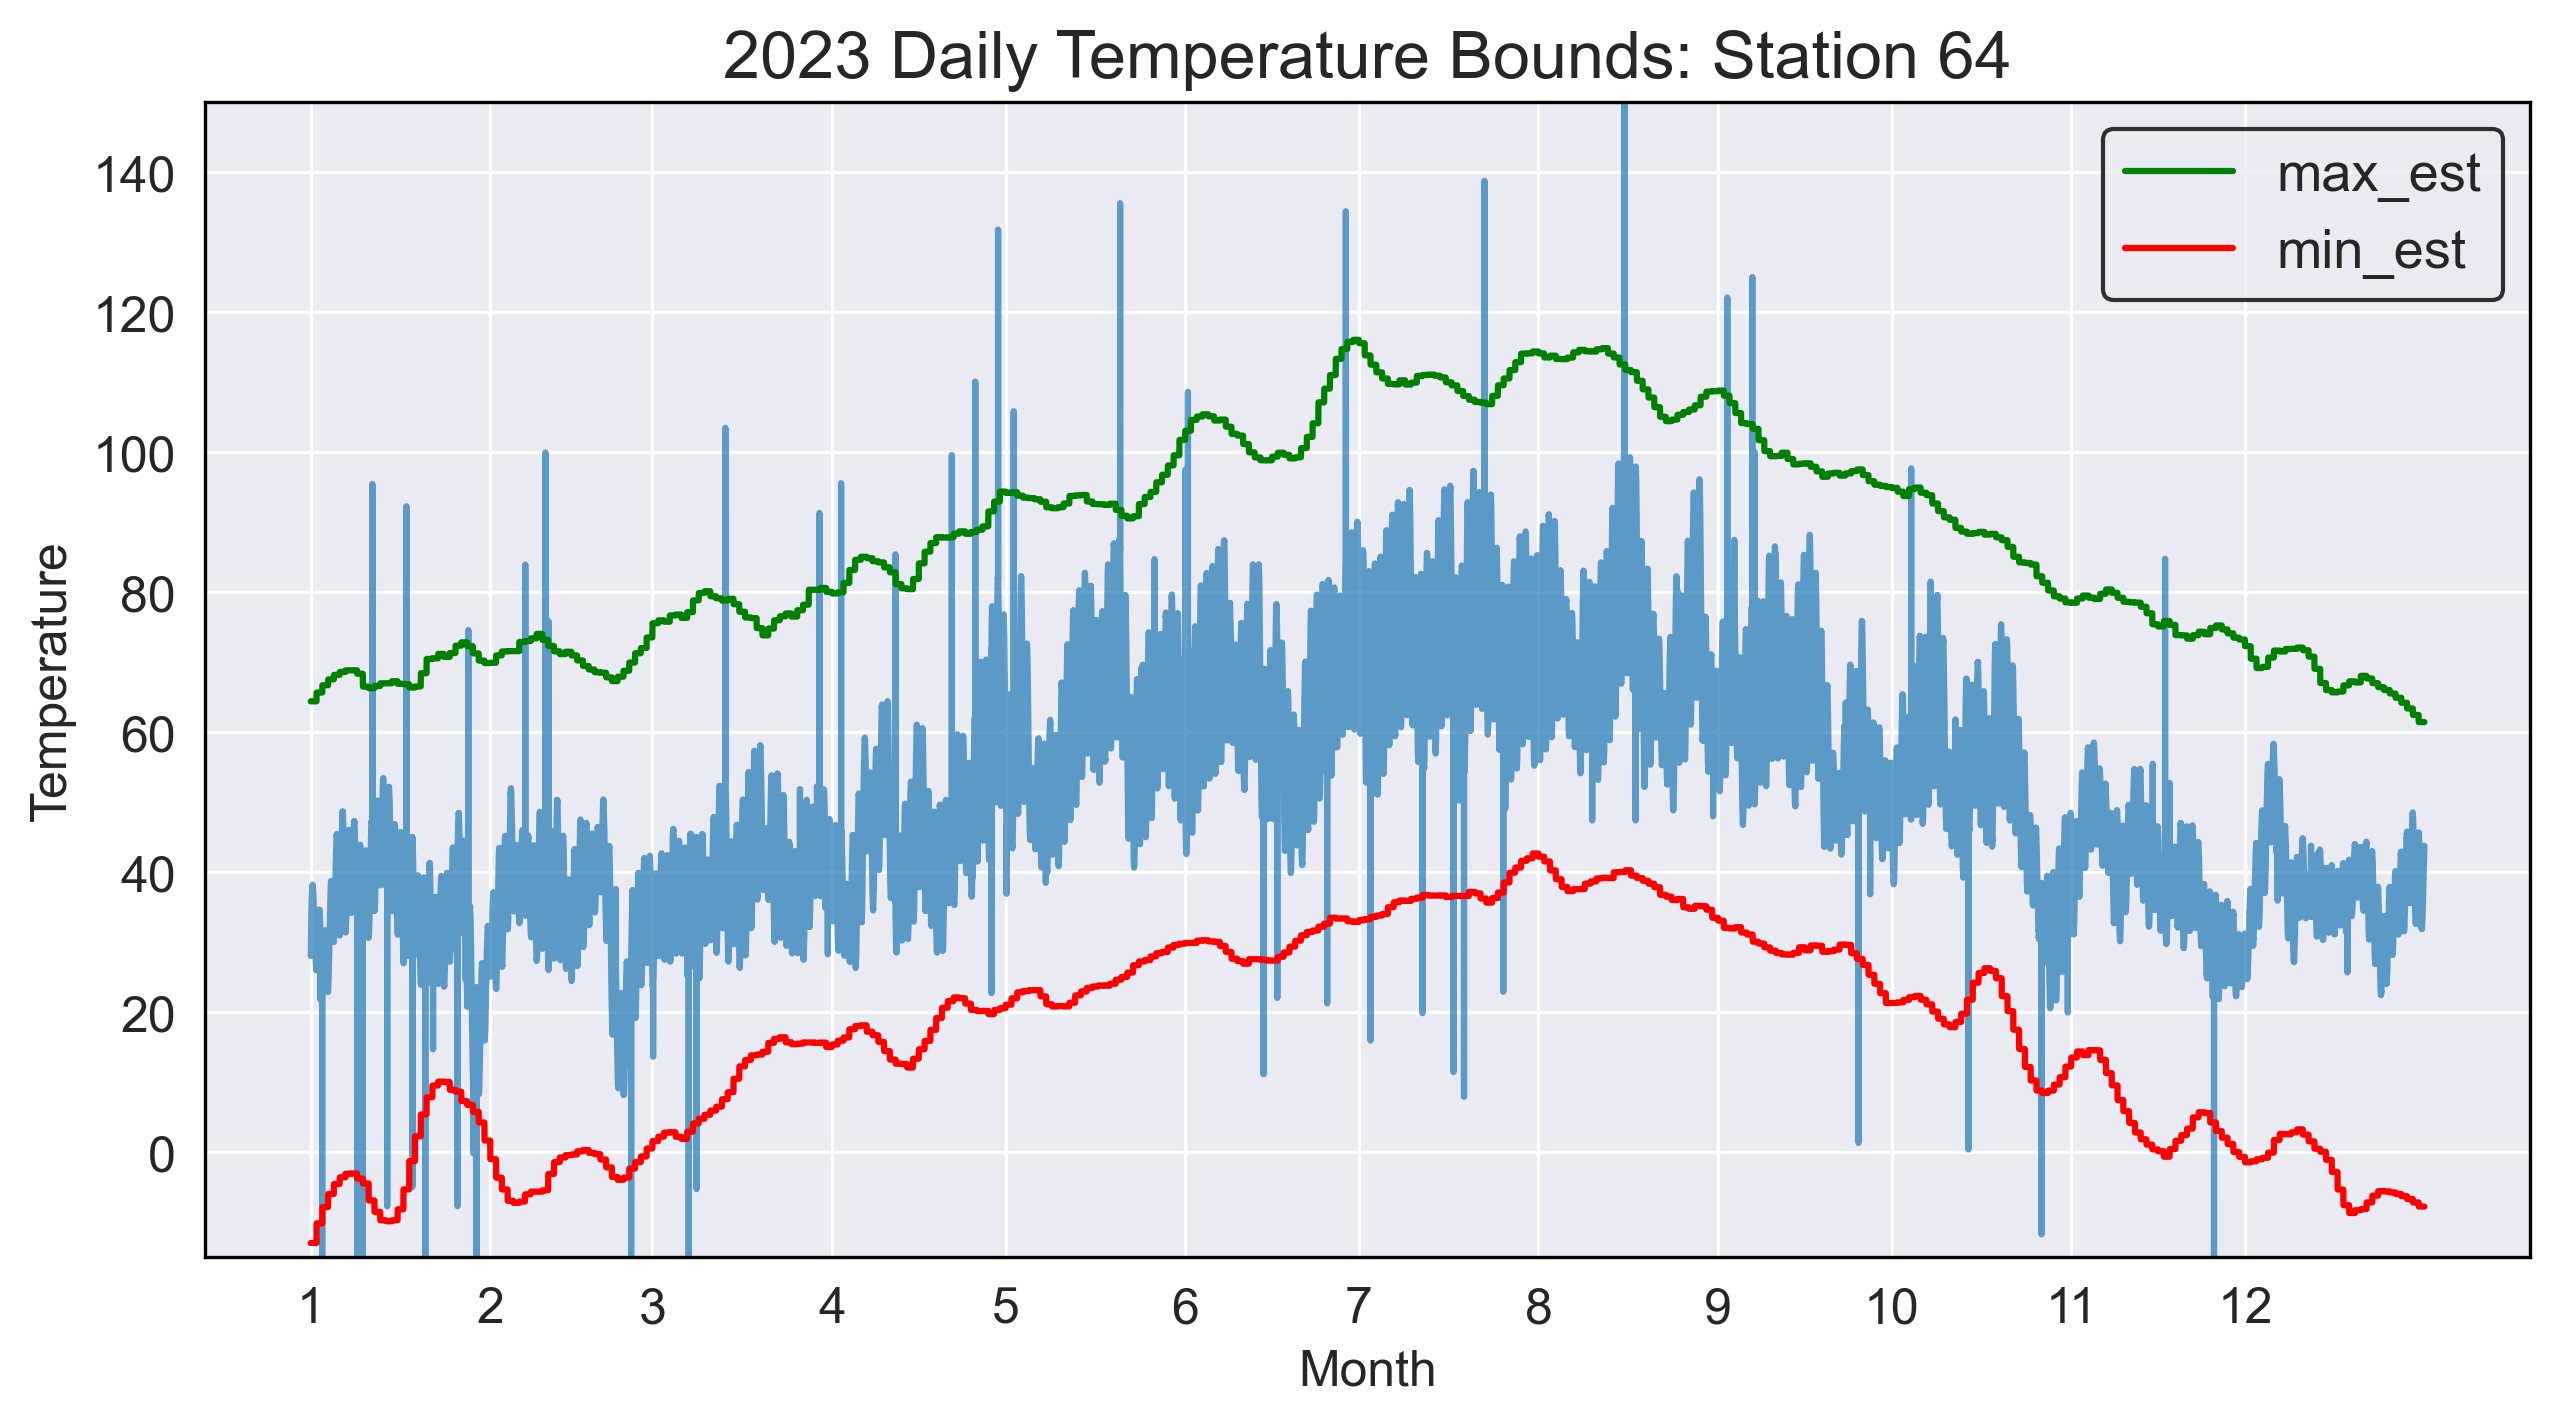

Flags Raised:
Too Hot: 23/35040 ; 0.07%
Too Cold: 23/35040 ; 0.07%
---------------------------------


In [6]:
n_flags = 100

error_data, idx_dict = error_injection(syn_data, n_flags, 50, 10)

# update error injection to return index values that are being changed
# update error injection to also work with delta values (10 degrees should be raised for delta, not bounds)
# create new function to take index, error data, and bounds estimates
## function should return accuracy (ignoring non-injected flags) for delta and bounds
## use the above in cross validation to create the table

# Generate graph with both daymet and das estimates to compare, on synthetic data
temp_val_graph(temp_est, error_data, s_num)

In [7]:
d_lb_acc, d_ub_acc, t_lb_acc, t_ub_acc = eval_metrics(error_data, temp_est, delta_est, idx_dict)

print(f"Temp LB Accuracy: {t_lb_acc*100}%")
print(f"Temp UB Accuracy: {t_ub_acc*100}%")
print("--------------------------")
print(f"Delta LB Accuracy: {d_lb_acc*100}%")
print(f"Delta UB Accuracy: {d_ub_acc*100}%")

Temp LB Accuracy: 88.0%
Temp UB Accuracy: 92.0%
--------------------------
Delta LB Accuracy: 100.0%
Delta UB Accuracy: 100.0%
